# Régression linéaire à plusieurs variables - Exercices tirés du MOOC d'Andrew Ng

## Chargement des données

Le jeu de données donne la valeur de plusieurs maisons, ainsi que leur taille (pieds carrés) et le nombre de chambres à coucher

### Chargez les données du fichier ex1data1.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [2]:
data = pd.read_csv("data.csv")

### Visualisez les données (valeurs réelles)

Maintenant, nous avons deux 'features'. Voyez si elles ont le même ordre de grandeur

In [3]:
data

,size,nb_bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900
5,1985,4,299900
6,1534,3,314900
7,1427,3,198999
8,1380,3,212000
9,1494,3,242500


## Définissez quelques variables utiles

### Définissez X et y

X est maintenant une matrice de dimensions m x 2

In [4]:
X = data.values[:,:2]  #convert dataframe to numpy array
y = np.array(data.price)

### Initialisez theta (combien de dimensions?)

In [5]:
theta = np.zeros(3)

### Vérifiez les dimensions de theta et de X. Sont-elles compatibles pour implémenter la fonction d'hypothèse sous forme vectorisée?

In [6]:
theta.shape, X.shape

((3,), (47, 2))

### Modifiez X en conséquence

In [7]:
X = np.c_[np.ones(X.shape[0]), X]

## Écrivez une fonction pour centrer et réduire les features

In [8]:
def featureNormalize(X):
    mean = X.mean(axis=0)
    stdev = X.std(axis=0)
    X = (X - mean)/stdev
    return X, mean, stdev

In [9]:
X[:,1:], mean, stdev = featureNormalize(X[:,1:])

### Maintenant nous allons devoir adapter nos fonctions _predict_, _fit_, et _cost_ à une situation à plusieurs variables

In [10]:
def predict(X, theta):
    return(np.dot(X, theta))

In [11]:
np.dot((predict(X, theta) - y), X)

array([-15999395.00, -4970914.27, -2571314.62])

In [12]:
def cost(X, y, theta):
    return ((1/(2 * X.shape[0])) * (np.sum((predict(X, theta) - y)**2)))

In [13]:
def fit_with_cost(X, y, theta, alpha, num_iters):
    m = X.shape[0]
    J_history = []
    for i in range(num_iters):
        theta = theta - (alpha/m) * np.dot((predict(X, theta) - y), X)
        J_history.append(cost(X, y, theta))
    return theta, J_history

## Lancez l'entrainement du modèle

Vous êtes libres de choisir alpha et num_iters cette fois!

In [14]:
theta, J_history = fit_with_cost(X, y, theta, 0.01, 3500)

## Visualisez l'évolution du coût (graphe de convergence)

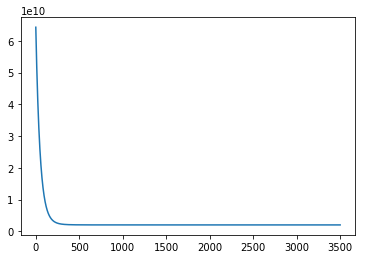

In [15]:
fit = plt.figure()
ax = plt.axes()
ax.plot(J_history)

## Testez votre modèle

Que vaut une maison de 1650 pieds carrés et de 3 chambres à coucher? (Si la valeur est aberrante, vous avez peut-être oublié une étape...)

In [16]:
X_test = (np.array([1650,3]) - mean) / stdev
X_test = np.hstack([1, X_test])
predict(X_test,theta)

293081.46686103614

### Réécrivez votre fonction fit pour qu'elle prenne en compte un parametre de regularisation (L1, L2 pour Lasso ou Ridge) et adapte la mise  a jour de theta an fonction de la regularization précisée

In [17]:
def fit_with_regularization(X, y, theta, alpha, num_iters, regularization="", lbda=0.1):
    m = X.shape[0]
    J_history = []
    
    reg = 0
    if regularization == "L1":
        reg = (lbda / m) * np.absolute(theta)
    elif regularization == "L2":
        reg = (lbda / m) * np.square(theta)

    for i in range(num_iters):
        theta = theta - (alpha/m) * (np.dot((predict(X, theta) - y), X) + reg)
        J_history.append(cost(X, y, theta))  
    return theta, J_history

[287954.18 101563.95 -2183.25]


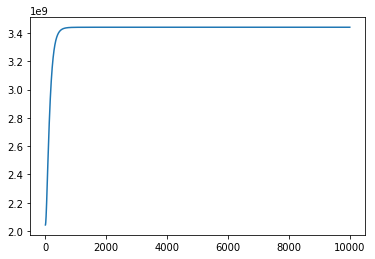

In [18]:
#theta = np.zeros(3)
theta, J_history = fit_with_regularization(X, y, theta, 0.01, 10000, regularization="L2", lbda=0.001)

fit = plt.figure()
ax = plt.axes()
ax.plot(J_history)
print(theta)

In [19]:
X_test = (np.array([1650,3]) - mean) / stdev
X_test = np.hstack([1, X_test])
predict(X_test,theta)

243145.8238105074

### La fonction fit au complet. Ajoutez un dernier parametre qui précise le gradient employé (stochastic, mini_batch(avec le batch_size), batch). Pour la descente de gradient stochastic et minibatch on met a jour le learning rate avec la formule du learning rate decay

In [127]:
import random


def learning_rate_decay(alpha_0, epochs, decay_rate):
    return((1 / (1 + decay_rate * epochs)) * alpha_0)


def batch_generator(X, y, batch_size):
    np.random.shuffle(X)
    size = X.shape[0]
    b_size = 0
    batches_X = []
    batches_y = []
    while (b_size + batch_size) < size:
        batches_X.append(X[b_size:(b_size + batch_size)])
        batches_y.append(y[b_size:(b_size + batch_size)])
        b_size += batch_size
    batches_X.append(X[b_size:size])
    batches_y.append(y[b_size:size])
    nb_batches = size // batch_size
    while True:
        rand_nb = random.randint(0,nb_batches-1)
        yield batches_X[rand_nb], batches_y[rand_nb]


def complete_fit(X,
                 y,
                 theta, 
                 alpha, 
                 num_iters, 
                 regularization="L1",
                 lbda=0.01,
                 gradient_descent="batch",
                 batch_size=4,
                 decay_rate=0.0):
    
    m = X.shape[0]
    J_history = []
    alpha_0 = alpha
    
    batch_s = m
    if gradient_descent == "batch":
        decay_rate = 0.0
        batch_s = m 
    elif gradient_descent == "mini_batch":
        batch_s = batch_size
    elif gradient_descent == "stochastic":
        batch_s = 1

    reg = 0
    if regularization == "L1":
        reg = (lbda / batch_s) * np.absolute(theta)
    elif regularization == "L2":
        reg = (lbda / batch_s) * np.square(theta)
        
    b_gen = batch_generator(X, y, batch_s)
    for epoch in range(num_iters):
        X_tmp, y_tmp = next(b_gen)
        theta = theta - (alpha/m) * (np.dot((predict(X_tmp, theta) - y_tmp), X_tmp) + reg)
        alpha = learning_rate_decay(alpha_0, epoch, decay_rate)
        J_history.append(cost(X_tmp, y_tmp, theta))  
    return theta, J_history

[8066.02 -1106.15 -1197.38]
[8066.02 -1106.15 -1197.38]


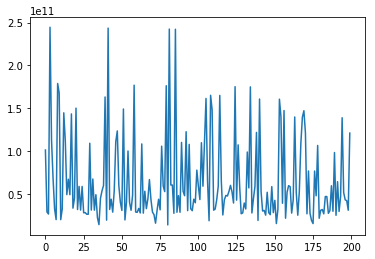

In [145]:
theta = np.zeros(3)
theta, J_history = complete_fit(X, y, theta, 0.01, 200,regularization="L1",
                                lbda=0.0, gradient_descent="stochastic", batch_size=16,
                                decay_rate=0.01)
print(theta)
fit = plt.figure()
ax = plt.axes()
ax.plot(J_history)
print(theta)

[109189.10 -18442.93 -3214.90]
[109189.10 -18442.93 -3214.90]


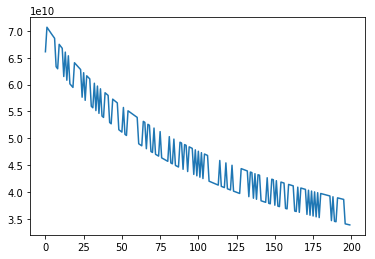

In [146]:
theta = np.zeros(3)
theta, J_history = complete_fit(X, y, theta, 0.01, 200,regularization="L1",
                                lbda=0.0, gradient_descent="mini_batch", batch_size=16,
                                decay_rate=0.01)
print(theta)
fit = plt.figure()
ax = plt.axes()
ax.plot(J_history)
print(theta)

[294804.28 -21073.98 21876.67]
[294804.28 -21073.98 21876.67]


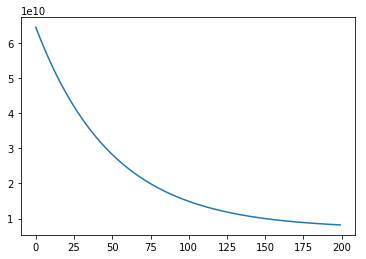

In [147]:
theta = np.zeros(3)
theta, J_history = complete_fit(X, y, theta, 0.01, 200,regularization="L1",
                                lbda=0.0, gradient_descent="batch", batch_size=16,
                                decay_rate=0.01)
print(theta)
fit = plt.figure()
ax = plt.axes()
ax.plot(J_history)
print(theta)